# This is for testing the main script

In [1]:
import os

print("Current Working Directory:", os.getcwd())
os.chdir('../')
print("New Working Directory:", os.getcwd())


Current Working Directory: c:\GitHub\Python\llm-review-analyzer\notebooks
New Working Directory: c:\GitHub\Python\llm-review-analyzer


In [2]:
from src.llms.models import *
from src.llms.prompts import *
from src.llms.predictions import *
from src.reviews.utilities import load_and_convert_all_from_folder
from tqdm import tqdm
import matplotlib.pyplot as plt
from langchain_community.document_loaders import DataFrameLoader
import pandas as pd
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_csv_agent
import numpy as np

In [3]:
df_orig = load_and_convert_all_from_folder()
if df_orig is None:
    raise ValueError("DataFrame is empty or not loaded properly")

2024-05-10 12:34:20,494 - INFO - Successfully loaded fake_apple.csv
2024-05-10 12:34:20,498 - INFO - Successfully loaded fake_google.csv


Cleaning Apple reviews...
Cleaning Google reviews...


In [4]:
df = predict_binary_single_model(df_orig=df_orig, model=chat_bison(), prompt_str=usable_review_binary_prompt)
df = df[df['usable'] == True]
df.drop('usable', axis=1, inplace=True)

Processing... : 100%|██████████| 39/39 [00:14<00:00,  2.68it/s]


In [5]:
df = topic_analysis(df_orig=df, model=chat_bison(), prompt_str=topics_prompt)

Processing... : 100%|██████████| 33/33 [00:11<00:00,  2.96it/s]


In [6]:
from langchain_google_vertexai import VertexAIEmbeddings
embedding_model = VertexAIEmbeddings(model_name='textembedding-gecko-multilingual@001',project=os.getenv('PROJECT'),location=os.getenv('LOCATION'))

In [261]:
reviews = df.to_records(index=False)
review_list = []

for review in reviews:
    review_list.append(str(review))



In [262]:
from deep_translator import GoogleTranslator

def translate_text(text_list):
    return GoogleTranslator(source='auto', target='en').translate_batch(batch=text_list)

In [138]:
df['translated'] = None
df['translated'] = translate_text(df['text'].to_list())


In [263]:
reviews = df.to_records(index=False)

In [264]:
from langchain_google_vertexai import VertexAIEmbeddings
from langchain.vectorstores import FAISS
import faiss
review_list=df['text'].tolist()
review_list_en = df['translated'].tolist()

In [265]:
def clean_review_list(review_list):
    new_list = []
    for review in review_list:
        clean_text = review.lower()
        new_list.append(clean_text)
    return new_list

In [321]:
new_List = clean_review_list(review_list=review_list_en)

In [322]:
len(new_List)

33

In [323]:
embedding_model = VertexAIEmbeddings(model_name='textembedding-gecko@003',project=os.getenv('PROJECT'),location=os.getenv('LOCATION'))
embeddings = embedding_model.embed(texts=new_List, embeddings_task_type='CLUSTERING')

In [324]:
embeddings_array = np.stack(embeddings)
d = embeddings_array.shape[1]
index = faiss.IndexFlatL2(d)  # Using L2 distance for similarity measure
embeddings_faiss = embeddings_array.astype(np.float32)
index.add(embeddings_faiss)



In [325]:
import faiss
import numpy as np

# Assume `embeddings_faiss` is your array of embeddings
d = embeddings_faiss.shape[1]  # Dimension of the embeddings

# Number of clusters
k = 10  # You can adjust this based on your needs

# Setting up K-means
kmeans = faiss.Kmeans(d, k, niter=25, verbose=True)
kmeans.train(embeddings_faiss)

# Assigning the reviews to clusters
D, I = kmeans.index.search(embeddings_faiss, 1)  # D is the distances, I is the indices of the clusters


In [331]:
clustered_reviews = {i: [] for i in range(k)}
for idx, cluster_id in enumerate(I.flatten()):
    clustered_reviews[cluster_id].append(review_list_en[idx])

# Display clustered reviews
for cluster_id, texts in clustered_reviews.items():
    print(f"Cluster {cluster_id}:")
    for text in texts:
        print(f" - {text}")


Cluster 0:
 - The app doesn’t always save settings changes, forcing me to redo them every time I log in
 - Every time I log in, I have to reset my password, even though I'm sure my password is correct. Very annoying
 - My settings are constantly being reset to defaults, causing me to have to reset everything regularly.
Cluster 1:
 - The color scheme is harsh and difficult to look at for long periods. A darker mode option would be appreciated
Cluster 2:
 - Notifications don’t clear automatically. It’s annoying to manually clear them every time
 - Language settings revert to default after updates, which is annoying.
Cluster 3:
 - The backup function is not working properly. I have lost important documents when I tried to back them up
 - PDF attachments often fail to open, showing 'error' messages. Needs urgent attention
 - Attachments sometimes get corrupted when downloaded through the app. Not reliable for important documents
 - The app keeps crashing when I try to open attachments. It'

In [327]:
clustered_reviews.items()

dict_items([(0, ['The app doesn’t always save settings changes, forcing me to redo them every time I log in', 'Varje gång jag loggar in, måste jag återställa mitt lösenord, trots att jag är säker på att mitt lösenord är korrekt. Mycket irriterande', 'Mina inställningar nollställs ständigt till standardinställningarna, vilket gör att jag måste ställa in allt på nytt regelbundet.']), (1, ['The color scheme is harsh and difficult to look at for long periods. A darker mode option would be appreciated']), (2, ['Notifications don’t clear automatically. It’s annoying to manually clear them every time', 'Language settings revert to default after updates, which is annoying.']), (3, ['Säkerhetskopieringsfunktionen fungerar inte som den ska. Jag har förlorat viktiga dokument när jag försökte säkerhetskopiera dem', "PDF attachments often fail to open, showing 'error' messages. Needs urgent attention", 'Attachments sometimes get corrupted when downloaded through the app. Not reliable for important 

In [328]:
results_with_scores = vectorstore.similarity_search_with_score("Buggy")
for doc, score in results_with_scores:
    print(f"Content: {doc.page_content}, Metadata: {doc.metadata}, Score: {score}")


Content: Okomplicerat, men buggy, Metadata: {'provider': 'Google', 'app_version': '3.35.4-3', 'rating': 2, 'last_updated': Timestamp('2024-04-02 18:10:06'), 'topic': ' App Functionality'}, Score: 0.5855915546417236
Content: Bra koncept men deras app behöver lite polering. Har stött på några buggar som gör användningen frustrerande ibland., Metadata: {'provider': 'Apple', 'app_version': 5.4, 'rating': 2, 'last_updated': Timestamp('2024-03-15 07:37:30'), 'topic': ' App Functionality'}, Score: 0.7895393967628479
Content: Attachments sometimes get corrupted when downloaded through the app. Not reliable for important documents, Metadata: {'provider': 'Google', 'app_version': '3.35.5-1', 'rating': 3, 'last_updated': Timestamp('2024-01-16 21:11:08'), 'topic': ' App Functionality'}, Score: 0.8103191256523132
Content: PDF attachments often fail to open, showing 'error' messages. Needs urgent attention, Metadata: {'provider': 'Google', 'app_version': '3.35.5-1', 'rating': 3, 'last_updated': Time

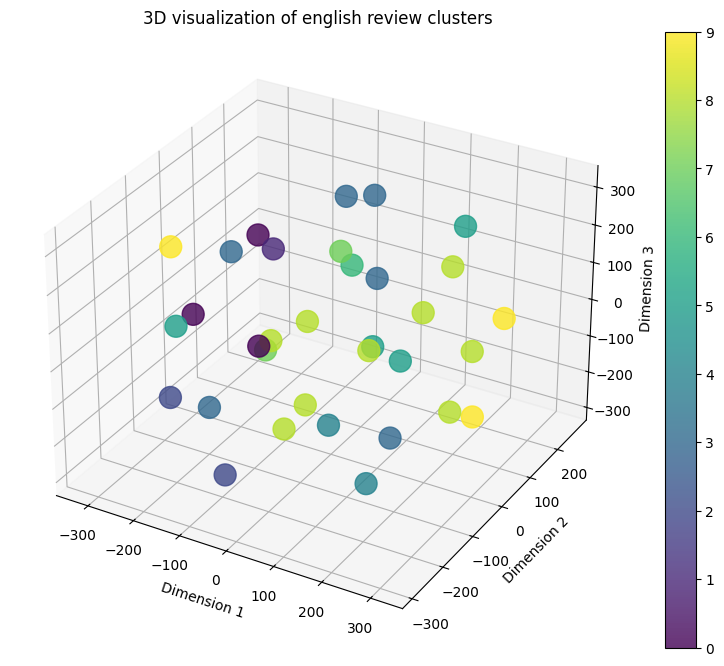

In [329]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform t-SNE dimensionality reduction to 3 components
tsne = TSNE(n_components=3, perplexity=30, n_iter=3000, random_state=42)
embeddings_reduced_3d = tsne.fit_transform(embeddings_faiss)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_reduced_3d[:, 0], embeddings_reduced_3d[:, 1], embeddings_reduced_3d[:, 2], c=I.flatten(), cmap='viridis', alpha=0.8, s=250)

# Annotate each point with its cluster number
'''for i, txt in enumerate(I.flatten()):
    ax.text(embeddings_reduced_3d[i, 0], embeddings_reduced_3d[i, 1], embeddings_reduced_3d[i, 2], txt)'''

ax.set_title('3D visualization of english review clusters')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.colorbar(scatter)
plt.show()

